In [275]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.signal import convolve2d

## Convolution 1D

In [172]:
input_1d = np.array([1, 2, 3, 4, 5])
kernel_1d = np.array([1, 1, 1])

In [173]:
def _pad_1d(inp: ndarray, num: int):
    z = np.zeros(num)
    return np.concatenate([z, inp, z]).astype("uint64")

In [174]:
_pad_1d(input_1d, 1)

array([0, 1, 2, 3, 4, 5, 0], dtype=uint64)

In [175]:
def conv_1d(inp: ndarray, param: ndarray):
    # pad the input
    param_len = param.shape[0]
    inp_pad = _pad_1d(inp, param_len // 2)
    
    # initialize the output
    out = np.zeros(inp.shape)
    
    # performing the 1d convolution
    for i in range(out.shape[0]):
        for j in range(param_len):
            out[i] += param[j] * inp_pad[i + j]
    
    return out

In [176]:
conv_1d(input_1d, kernel_1d)

array([ 3.,  6.,  9., 12.,  9.])

In [177]:
def conv_1d_sum(inp: ndarray, param: ndarray):
    out = conv_1d(inp, param)
    return np.sum(out)

In [178]:
conv_1d_sum(input_1d, kernel_1d)

39.0

## 2D Convolution

In [297]:
def pad_2d(image_arr: ndarray, kernel_size):
    N, M = image_arr.shape
    m, n = kernel_size
    
    n_rows = int((m - 1) / 2)
    n_cols = int((n - 1) / 2)
    
    # add top and bottom padding
    top_bottom_zeros = np.zeros((n_rows, M))
    image_arr = np.vstack([top_bottom_zeros, image_arr, top_bottom_zeros])
    
    # add left and right padding
    left_bottom_zeros = np.zeros((N + n_rows * 2, n_cols)) # (m - 1) rows need to be added
    image_arr = np.hstack([left_bottom_zeros, image_arr, left_bottom_zeros])
    
    image_arr = image_arr.astype('uint64')
    
    return image_arr

In [298]:
np.random.seed(1069)

img_arr = np.random.randint(255, size=(3, 3))
img_arr

array([[228, 145, 169],
       [249, 188, 172],
       [248,  43, 228]])

In [299]:
kernel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1],
])

In [300]:
pad_2d(img_arr, kernel.shape)

array([[  0,   0,   0,   0,   0],
       [  0, 228, 145, 169,   0],
       [  0, 249, 188, 172,   0],
       [  0, 248,  43, 228,   0],
       [  0,   0,   0,   0,   0]], dtype=uint64)

In [301]:
def inner_product(a: ndarray, b: ndarray):
    return np.sum(a * b)

In [315]:
def conv_2d(inp: ndarray, kernel: ndarray) -> ndarray:
    
    # pad the image
    inp_pad = pad_2d(inp, kernel.shape)
    
    # initialize the output
    out = np.zeros_like(inp)
    
    # flip the kernel horizontally and vertically
    kernel = np.flipud(np.fliplr(kernel))
    
    # convolution process
    for i in tqdm(range(inp_pad.shape[0] - kernel.shape[0] + 1)):
        for j in range(inp_pad.shape[1] - kernel.shape[1] + 1):
            sub_arr = inp_pad[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            out[i, j] = inner_product(sub_arr, kernel)
    
    return out

In [313]:
conv_2d(img_arr, kernel)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


array([[-686, -797, -532],
       [  62,  125,  -16],
       [ 686,  797,  532]])

In [316]:
# compare with the scipy's convolve method
convolve2d(img_arr, kernel, mode="same")

array([[-686, -797, -532],
       [  62,  125,  -16],
       [ 686,  797,  532]])

Both are same 

## Application

In [317]:
def read_image(image_path):
    with open(image_path) as f_obj:
        data = f_obj.readlines()

    # metadata = list(map(lambda x: x.strip(), data[:4]))
    img_data = list(map(lambda x: int(x.strip()), data[4:]))
    
    img_width, img_height = map(int, metadata[2].split(" "))
    
    return np.array(img_data).reshape((img_height, img_width))

In [318]:
img_arr = read_image("alan.pgm")
img_arr

array([[255, 255, 255, ..., 255, 255, 255],
       [120, 120, 120, ...,  92,  92, 255],
       [120, 120, 120, ...,  92,  92, 255],
       ...,
       [ 92,  86,  86, ..., 143, 143, 255],
       [108, 100, 100, ..., 167, 167, 255],
       [118, 112, 112, ..., 157, 157, 255]])

In [319]:
img_arr.shape

(849, 649)

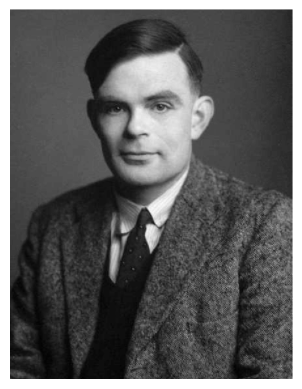

In [320]:
plt.imshow(img_arr, cmap="gray")
plt.axis("off")
plt.show()

In [327]:
filtered_img = conv_2d(img_arr, kernel)

100%|████████████████████████████████████████████████████████████████████████████████| 849/849 [00:38<00:00, 22.13it/s]


In [328]:
filtered_img

array([[-360, -480, -478, ..., -368, -531, -602],
       [ 405,  540,  542, ...,  652,  489,  163],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ -46,  -58,  -52, ...,  -88,  -72,  -24],
       [ -78, -104, -100, ...,  -48,  -42,  -14],
       [ 316,  408,  390, ...,  654,  756,  677]])

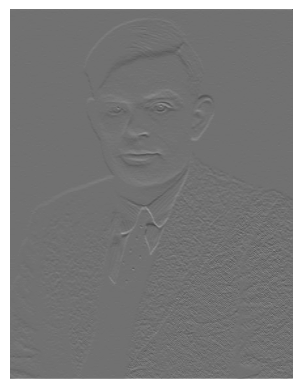

In [329]:
plt.imshow(filtered_img, cmap="gray")
plt.axis("off")
plt.show()

In [330]:
filtered_img_scipy = convolve2d(img_arr, kernel, mode="same")
print(filtered_img)

[[-360 -480 -478 ... -368 -531 -602]
 [ 405  540  542 ...  652  489  163]
 [   0    0    0 ...    0    0    0]
 ...
 [ -46  -58  -52 ...  -88  -72  -24]
 [ -78 -104 -100 ...  -48  -42  -14]
 [ 316  408  390 ...  654  756  677]]


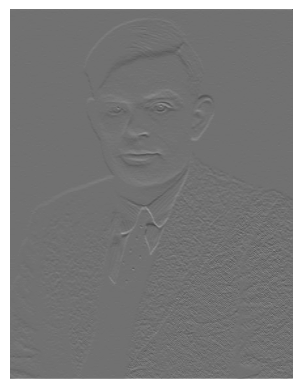

In [331]:
plt.imshow(filtered_img_scipy, cmap="gray")
plt.axis("off")
plt.show()

In [332]:
np.array_equal(filtered_img, filtered_img_scipy)

True